In [82]:
import gensim

import music21
import numpy as np
import matplotlib.pyplot as plt
import functools
import glob
import word2vec

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

from glove import Glove
from glove import Corpus

from collections import Counter

import timeit

In [59]:
@functools.lru_cache(maxsize=None)
def c_to_strep(c):
    rep = ""
    for i in range(12):
        if i in c.pitchClasses:
            rep += "1"
        else:
            rep += "0"
    return rep

@functools.lru_cache(maxsize=None)
def strep_to_c(strep):
    pcs = []
    for i, v in enumerate(strep):
        if v == '1':
            pcs.append(i)
    return music21.chord.Chord(pcs)

def transpose_to_all(c):
    out = []
    old = c
    for i in range(12):
        new = old.transpose(7)
        out.append(new)
        old = new
    return out

In [273]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [l for l in f.read().split(' ') if l != '']
    return data

In [275]:
def train_google(path_to_corpus,cbow=0):
    word2vec.word2vec(path_to_corpus,output='google.bin',size=EMBEDDING_SIZE,window=CONTEXT_WINDOW,
                      min_count=MIN_COUNT,sample=0,cbow=cbow)
    model = word2vec.load('google.bin')
    l = list(model.vocab)
    e = model.vectors
    return e, l

In [326]:
def collect_rand_walk(name):
    basepath = '/home/eamonn/Projects/SemanticVector/examples/vector_result/'
    with open(basepath+'{}.txt'.format(name)) as f:
        lines = f.readlines()
    
    l = [l.split(' ')[0] for l in lines]
    a = np.loadtxt(basepath+'{}_rw_vectors.txt'.format(name))
    e = a[:,1:]
    return e, l

In [327]:
def filter_tokens(tokens, min_count):
    c = Counter(tokens)
    filtered = {k: v for k, v in dict(c).items() if v >= min_count}.keys()
    return [t for t in tokens if t in filtered]
    
def train_glove(tokens):    
    filtered_tokens = filter_tokens(tokens, min_count=MIN_COUNT)
    
    corpus_model = Corpus()
    corpus_model.fit([filtered_tokens], window=CONTEXT_WINDOW)

    glove = Glove(no_components=EMBEDDING_SIZE, learning_rate=0.05)
    glove.fit(corpus_model.matrix, epochs=150,
              no_threads=4, verbose=False)
    glove.add_dictionary(corpus_model.dictionary)

    l = list(glove.dictionary.keys())
    e = np.array([glove.word_vectors[glove.dictionary[label]] for label in l])
    return e, l, glove

In [328]:
def scatter_only(embeddings,labels,to_plot,color='black',n_components=2,x_component=0, y_component=1,marker='o'):
    to_plot_indices = [labels.index(strep) for strep in to_plot]
    pca = PCA(n_components=n_components)
    proj = pca.fit_transform(embeddings)
    subset = proj[to_plot_indices]
    plt.scatter(subset[:,x_component], subset[:,y_component],color=color,marker=marker)

def connectors(embeddings,labels,line_origin,line_destination,color='black',n_components=2,x_component=0, y_component=1):
    origin_indices = [labels.index(strep) for strep in line_origin]
    destination_indices = [labels.index(strep) for strep in line_destination]
    pca = PCA(n_components=n_components)
    proj = pca.fit_transform(embeddings)
    
    origin_subset = proj[origin_indices]
    destination_subset = proj[destination_indices]
    
    for o, d in zip(origin_subset, destination_subset):
        plt.plot([o[x_component], d[x_component]], [o[y_component], d[y_component]],
                 linestyle='--',color=color)

In [329]:
def all_examples(pitches):
    c = music21.chord.Chord(pitches)
    all_ = transpose_to_all(c)
    all_strep = [c_to_strep(c) for c in all_]
    return all_strep

# Parameters

In [451]:
EMBEDDING_SIZE = 100
CONTEXT_WINDOW = 5
MIN_COUNT = 5
CORPUS = 'billboard'

In [452]:
path_to_corpus = '../../corpuscule/ycac/corpus/{}.corpus'.format(CORPUS)
tokens = read_data(path_to_corpus)
# tokens = read_data('../tf/lite.corpus')

In [453]:
wce, wcl = train_google(path_to_corpus,cbow=1)

In [454]:
len(tokens)

124895

In [418]:
wse, wsl = train_google(path_to_corpus,cbow=0)

In [419]:
ge, gl, glove_model = train_glove(tokens)

In [420]:
re, rl = collect_rand_walk('{}.corpus'.format(CORPUS))

In [421]:
wce.shape, wse.shape, ge.shape, re.shape

((1001, 100), (1001, 100), (1000, 100), (1000, 100))

### Are the vectors normalized?

In [388]:
for e, l in [(wce, wcl), (wse, wsl), (ge, gl), (re, rl)]:
    norms = [np.linalg.norm(v) for v in e]
    print(np.mean(norms))

1.00000000007
1.00000000249
1.9017885906
1.3646483156


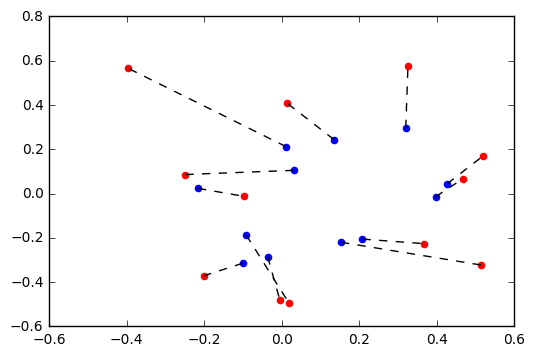

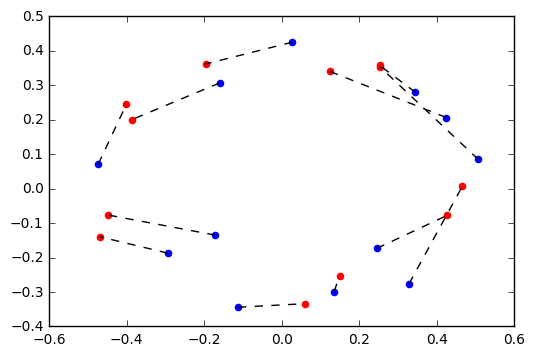

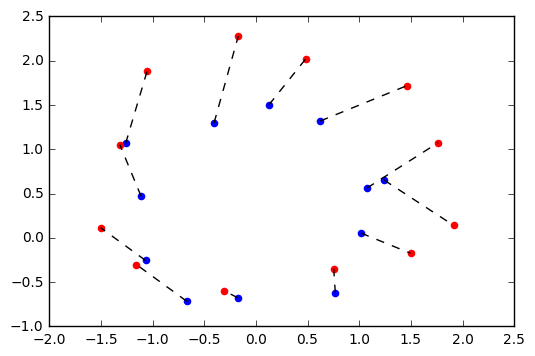

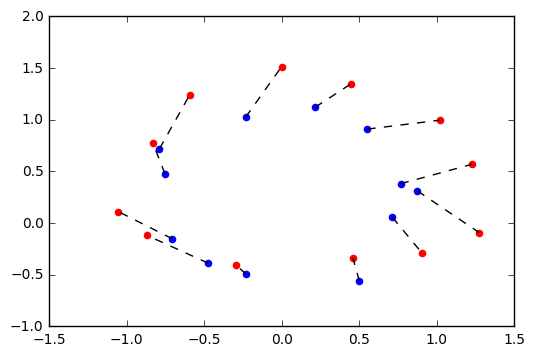

In [389]:
for e, l in [(wce, wcl), (wse, wsl), (ge, gl), (re, rl)]:
    n_components = 2
    x_component = 0
    y_component = 1
    
    A = 'G B D F'
    B = 'C E G'
    
    scatter_only(e, l, all_examples(A),color='blue',n_components=n_components,
                x_component=x_component,y_component=y_component)
    scatter_only(e, l, all_examples(B),color='red',n_components=n_components,
                x_component=x_component,y_component=y_component)
    #scatter_only(e, l, all_examples('G B- D F '),color='green')
    connectors(e, l, all_examples(A), all_examples(B),n_components=n_components,
                x_component=x_component,y_component=y_component)
    #plt.xlim([-2,2])
    #plt.ylim([-2,2])

    plt.show()
    plt.close()

In [390]:
plt.close()

In [391]:
def scatter_only_3d(embeddings,labels,to_plot,color='black'):
    to_plot_indices = [labels.index(strep) for strep in to_plot]
    pca = PCA(n_components=3)
    proj = pca.fit_transform(embeddings)
    subset = proj[to_plot_indices]
    ax.scatter(subset[:,0], subset[:,1],subset[:,2],color=color)

## Evaluating model performance on analogy task

In [392]:
def load_analogies(fn):
    with open(fn, 'r') as f:
        analogies = [l.strip().split('\t') for l in f.readlines()]
    return analogies

In [393]:
def pairdirection(v_a, v_a_star,v_b,v_b_star):
    return float(cosine_similarity((v_b_star-v_b),(v_a_star-v_a)))

In [394]:
def cosadd3(v_a,v_a_star,v_b,v_b_star):
    """COSADD3 = cos(b*,b) - cos(b*,a) + cos(b*,a*)"""
    return float(cosine_similarity(v_b_star, v_b) - cosine_similarity(v_b_star, v_a) + cosine_similarity(v_b_star,v_a_star))

In [395]:
def cosmul3(v_a,v_a_star,v_b,v_b_star,epsilon=0.0001,debug=False):
    """COSMUL3 = cos(b*,b)cos(b*,a*)/(cos(b*,a) + epsilon)
               = PQ/(R+e)
    P,Q,R are all transformed versions of each term so that they fit on [0,1]"""
    
    def transform(sim):
        return (sim + 1)/2
    
    P = transform(cosine_similarity(v_b_star,v_b))
    Q = transform(cosine_similarity(v_b_star,v_a_star))
    R = transform(cosine_similarity(v_b_star, v_a))
    
        
    if debug:
        print("P:{} Q:{} P*Q:{} R:{}".format(P, Q, P*Q, R))
        
    return float((P*Q)/(R + epsilon))

In [396]:
len(analogies)

132

In [397]:
def predict_analogy(e,l,a,a_star,b,objective,top_n=1):
    v_a = e[l.index(a)].reshape(1, -1)
    v_a_star = e[l.index(a_star)].reshape(1, -1)
    v_b = e[l.index(b)].reshape(1, -1)
    
    results = {}
    for i, v_b_star in enumerate(e):
        results[i] = objective(v_a,v_a_star,v_b,v_b_star.reshape(1, -1))
    
    sorted_results = sorted(results,key=results.get,reverse=True)
    result = [l[i] for i in sorted_results[:top_n]]
    
    return result

In [445]:
def evaluate_model_providing_rankings(e, l, analogies,objective,g=lambda x:x):
    ranks = []
    filtered_ranks = []
    for analogy in analogies:
        a,a_star,b,actual = analogy
        top_n = e.shape[0]
        ranked_predictions = predict_analogy(e,l,a,a_star,b,
                                             objective=objective,
                                             top_n=top_n)
        
        filtered_ranked_predictions = list(filter(g, ranked_predictions))
        
        ranks.append(ranked_predictions.index(actual))
        filtered_ranks.append(filtered_ranked_predictions.index(actual))
    return ranks, filtered_ranks

In [446]:
def is_major_triad(strep):
    try:
        c = strep_to_c(strep)
        cn = c.commonName
        if 'major triad' in cn:
            return True
        else:
            return False
    except:
        False

In [447]:
def score(e,l,analogies,objective):
    rankings, filtered_rankings = evaluate_model_providing_rankings(e, l, analogies,
                                                                    objective=objective,g=is_major_triad)
    rankings_array = np.array(rankings)
    
    def p_at(a,n): 
        return sum(a < n) / len(a)
    print('--------')
    print('open vocabulary')
    print('\tp@1={:.4f}\tp@3={:.4f}\tp@5={:.4f}\tp@10={:.4f}'.format(p_at(rankings_array,1), 
                                                                    p_at(rankings_array,3), 
                                                                    p_at(rankings_array,5), 
                                                                    p_at(rankings_array,10)))
    
    filtered_rankings_array = np.array(filtered_rankings)
    print('--------')
    print('closed vocabulary (major triads)')
    print('\tp@1={:.4f}\tp@3={:.4f}\tp@5={:.4f}\tp@10={:.4f}'.format(p_at(filtered_rankings_array,1), 
                                                                    p_at(filtered_rankings_array,3), 
                                                                    p_at(filtered_rankings_array,5), 
                                                                    p_at(filtered_rankings_array,10)))
    return p_at(filtered_rankings_array,1)

In [448]:
%%time
analogies = load_analogies('analogies_D1T1D2T2.eval')
print("results of analogy reconstruction")
print("analogy set 'analogies_D1T1D2T2.eval'")
for model_name, test_embedding, test_labels in [('word2vec_sg',wse, wsl), 
                                                ('word2vec_cbow',wce, wcl), 
                                                ('glove',ge, gl),
                                                ('RAND-WALK',re, rl),
                                                ]:
    print("========")
    print("model: {} (3CosMul objective)".format(model_name))
    score(test_embedding, test_labels, analogies=analogies, objective=cosmul3)
    #print("model: {} (3CosAdd objective)".format(model_name))
    #score(test_embedding, test_labels, analogies=analogies, objective=cosadd3)
    #print("model: {} (PairDirection objective)".format(model_name))
    #score(test_embedding, test_labels, analogies=analogies, objective=pairdirection)

results of analogy reconstruction
analogy set 'analogies_D1T1D2T2.eval'
model: word2vec_sg (3CosMul objective)
--------
open vocabulary
	p@1=0.0000	p@3=0.0000	p@5=0.0000	p@10=0.0000
--------
closed vocabulary (major triads)
	p@1=0.0909	p@3=0.7576	p@5=0.9470	p@10=1.0000
model: word2vec_cbow (3CosMul objective)
--------
open vocabulary
	p@1=0.0076	p@3=0.0076	p@5=0.0227	p@10=0.0530
--------
closed vocabulary (major triads)
	p@1=0.1894	p@3=0.8939	p@5=0.9924	p@10=1.0000
model: glove (3CosMul objective)
--------
open vocabulary
	p@1=0.0000	p@3=0.0227	p@5=0.0682	p@10=0.2576
--------
closed vocabulary (major triads)
	p@1=0.2348	p@3=0.8712	p@5=0.9697	p@10=1.0000
model: RAND-WALK (3CosMul objective)
--------
open vocabulary
	p@1=0.0152	p@3=0.0379	p@5=0.0985	p@10=0.2727
--------
closed vocabulary (major triads)
	p@1=0.1818	p@3=0.9470	p@5=0.9773	p@10=1.0000
CPU times: user 3min 2s, sys: 1.27 s, total: 3min 3s
Wall time: 3min 2s


## Failure to solve analogies

In [171]:
import random

In [172]:
def strep_to_human(strep):
    return strep_to_c(strep).root().name + " " + strep_to_c(strep).commonName

In [177]:
ge[0].reshape(1, -1).shape

(1, 100)

In [221]:
for analogy in analogies:
    a, a_star, b, actual = analogy
    things = (a, a_star, b, actual)
    human_things = [strep_to_human(strep) for strep in things]

    proposals = predict_analogy(re,rl,a,a_star,b,cosmul3,top_n=2)
    proposal = proposals[0]
    if actual == proposal:
        print(" ".join(human_things))
        print("computer said {}; needed {}".format(strep_to_human(proposal), 
                                                      strep_to_human(actual)))

D dominant seventh chord D dominant seventh chord G major triad G major triad
computer said G major triad; needed G major triad
D dominant seventh chord D# dominant seventh chord G major triad A- major triad
computer said A- major triad; needed A- major triad
D dominant seventh chord C dominant seventh chord G major triad F major triad
computer said F major triad; needed F major triad
A dominant seventh chord A dominant seventh chord D major triad D major triad
computer said D major triad; needed D major triad
A dominant seventh chord B- dominant seventh chord D major triad E- major triad
computer said E- major triad; needed E- major triad
A dominant seventh chord G dominant seventh chord D major triad C major triad
computer said C major triad; needed C major triad
E dominant seventh chord E dominant seventh chord A major triad A major triad
computer said A major triad; needed A major triad
E dominant seventh chord B- dominant seventh chord A major triad E- major triad
computer said E-